### Load Packages

In [1]:
# Link to Drive
from google.colab import drive
drive.mount('/content/drive')

# Connect to Earth Engine
import ee
ee.Authenticate()
ee.Initialize()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=J1bNxbsuRYG5zkWeo4noQuoSfgkPNuRmAB-6ChQyN5A&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWjs8f8ZlY5IdoEsdnaXkkXeYYg1e21tb2sQ63YQCg9-jOwzsaPPQMU

Successfully saved authorization token.


In [2]:
import os
from glob import glob
!pip install shapely
!pip install geopandas
!pip install xarray
!pip install rioxarray
!pip install wxee

import shapely as shp
import geopandas as gpd
import wxee
import numpy as np
import matplotlib.pyplot as plt


## User-defined Functions

In [4]:
# Get border coords as input to GEE, Using list comprehension
def getBorder(polygon):
  x,y = polygon.exterior.coords.xy
  border = [[lon, lat] for lon, lat in zip(x,y)]
  return border

# Usual For-loop
#border = []
#for i in range(len(roi_merged)):
#  x,y = roi_merged[i].exterior.coords.xy
#  border.append([[lon,lat] for lon, lat in zip(x,y)])
#border[1]

In [5]:
# Function to Mask Clouds
def maskCloud(image):
  cloudMask = image.select(['pixel_qa']).bitwiseAnd(1<<5).eq(0)
  cloudShadowMask = image.select(['pixel_qa']).bitwiseAnd(1<<3).eq(0)
  final_mask = cloudMask.And(cloudShadowMask)
  return image.updateMask(final_mask)

In [6]:
# Function for Smoothing
def smooth(image):
  kernel = ee.Kernel.square(radius = 3, units = 'pixels', normalize = True)
  return image.convolve(kernel)

In [7]:
def addNDWI(image):
  index = waterIndex
  #ndwi_mcf = image.normalizedDifference(['green', 'nir']).rename(['ndwiMCF'])
  newBand = image.normalizedDifference(['green', 'swir']).rename([index])
  return image.addBands([newBand])


In [8]:
#def filterPercentiles(image):
  
#  boolean = image.lt(P_95_ndwi).And(image.gt(P_05_ndwi))
  # Make a boolean showing if image meets conditions
#  boolMask = boolean.selfMask()
  # Create a mask from boolean

#  return image.updateMask(boolMask)
  # Apply mask to image

In [9]:
def quantile(year):

  index = waterIndex

  # Subset to one year stack of selected index
  ls_oneyear = ls_ndwi.select([index]).filter(ee.Filter.calendarRange(year, year, 'year'))

  # Get Quantile of one year
  P_95_ndwi = ls_oneyear.reduce(ee.Reducer.percentile([97.5]))#.select(index+'_p98')
  P_05_ndwi = ls_oneyear.reduce(ee.Reducer.percentile([2.5]))#.select(index+'_p3')


  #######################################################
  def filterPercentiles(image):
  
    boolean = image.lt(P_95_ndwi).And(image.gt(P_05_ndwi))
    # Make a boolean showing if image meets conditions
    boolMask = boolean.selfMask()
    # Create a mask from boolean

    return image.updateMask(boolMask)
    # Apply mask to image
  ########################################################

  # Update each image in one year stack with the quantiles
  ls_quantiled = ls_oneyear.map(filterPercentiles)

  # Reduce to Min.
  ls_reduced = ls_quantiled.min().set({'year':year, 'system:time_start':ee.Date.fromYMD(year,12,31)})

  return ls_reduced

In [10]:
# Function of ostu's method
def otsu(histogram):
    counts = ee.Array(ee.Dictionary(histogram).get('histogram'))
    means = ee.Array(ee.Dictionary(histogram).get('bucketMeans'))
    size = means.length().get([0])
    total = counts.reduce(ee.Reducer.sum(), [0]).get([0])
    sum = means.multiply(counts).reduce(ee.Reducer.sum(), [0]).get([0])
    mean = sum.divide(total)

    indices = ee.List.sequence(1, size)

    def iFunc(i):
      aCounts = counts.slice(0, 0, i) 
      aCount = aCounts.reduce(ee.Reducer.sum(), [0]).get([0])
      aMeans = means.slice(0, 0, i)
      aMean = aMeans.multiply(aCounts).reduce(ee.Reducer.sum(),[0]).get([0]).divide(aCount)
      bCount = total.subtract(aCount)
      bMean = sum.subtract(aCount.multiply(aMean)).divide(bCount)
      return aCount.multiply(aMean.subtract(mean).pow(2)) \
            .add(bCount.multiply(bMean.subtract(mean).pow(2)))

    # Compute between sum of squares, where each mean partitions the data
    bss = indices.map(iFunc)

    return means.sort(bss).get([-1])

In [11]:
# Function of Otsu's Method
def thresholding(image):
  
  index = waterIndex

  #Compute the histogram of the NIR band. (the mean and variance are only FYI)
  histogram = image.select([index]).reduceRegion(
      reducer = ee.Reducer.histogram(255,2).combine('mean', None, True).combine('variance', None, True),
      geometry = roi.getInfo(),
      scale = 30,
      bestEffort = True)
  
  threshold = otsu(histogram.get(index+'_histogram'))
  water = image.select([index]).lt(threshold)
  return water.rename(['watermask']) \
              .clip(roi) \
              .copyProperties(image) \
              .set('system:time_start', ee.Date.fromYMD(image.get('year'), 12, 31))

In [12]:
#def ndwiThreshold(image):
#  BAND = 'ndwi'
#  return image.select([BAND]).gte(0.3) \
#              .rename(['watermask'])\
#              .clip(roi) \
#              .copyProperties(image) \
#              .set('system:time_start', ee.Date.fromYMD(image.get('year'), 12, 31))

In [13]:
# Function to have difference between two years
def annual_diff(list):
  diff = ee.Image(ee.List(list).get(1)).subtract(
      ee.Image(ee.List(list).get(0))
  )
  return diff.set({'year': ee.Image(ee.List(list).get(1)).get('year'),
                   'system:time_start': ee.Image(ee.List(list).get(1)).get('system:time_start')})

In [14]:
# Function for remapping
def remap_gain(image):
  gain = image.eq(1).selfMask()
  return gain.remap([1], ee.List([image.get('year')])) \
             .rename('gain_year') \
             .copyProperties(image)

In [15]:
# Function for unite pixel type
def unipt(image):
  return image.cast({'gain_year': ee.PixelType('int', 1984, 2019)})             

In [16]:
# Function to Visualize
import folium

# Define the URL format used for Earth Engine generated map tiles.
EE_TILES = 'https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}'
print('Folium version: ' + folium.__version__)


# Mapdisplay: Display GEE objects using folium.
def Mapdisplay(center, dicc, Tiles="OpensTreetMap",zoom_start=10):
    '''
    :param center: Center of the map (Latitude and Longitude).
    :param dicc: Earth Engine Geometries or Tiles dictionary
    :param Tiles: Mapbox Bright,Mapbox Control Room,Stamen Terrain,Stamen Toner,stamenwatercolor,cartodbpositron.
    :zoom_start: Initial zoom level for the map.
    :return: A folium.Map object.
    '''
    mapViz = folium.Map(location=center,tiles=Tiles, zoom_start=zoom_start)
    for k,v in dicc.items():
      if ee.image.Image in [type(x) for x in v.values()]:
        folium.TileLayer(
            tiles = v["tile_fetcher"].url_format,
            attr  = 'Google Earth Engine',
            overlay =True,
            name  = k
          ).add_to(mapViz)
      else:
        folium.GeoJson(
        data = v,
        name = k
          ).add_to(mapViz)
    mapViz.add_child(folium.LayerControl())
    return mapViz

Folium version: 0.8.3


## Prepare ROI (Asia) for processing

### Load one-country parcels

In [17]:
# Change Working Directory
#os.chdir('/content/drive/MyDrive/THESIS_AQUAPONDS/ROI/Aquaculture_Asia_Coast_2019/Coastline_parcels_polygon')
os.chdir('/content/drive/MyDrive/THESIS_AQUAPONDS/ROI/Aquaculture_Asia_Coast_2019')
os.getcwd()

'/content/drive/MyDrive/THESIS_AQUAPONDS/ROI/Aquaculture_Asia_Coast_2019'

In [18]:
# Set Paths to Parcels
path_parcels = glob(os.path.join(os.getcwd(), 'Coastline_parcels_polygon', '*.gpkg'))[0]
print(path_parcels)

/content/drive/MyDrive/THESIS_AQUAPONDS/ROI/Aquaculture_Asia_Coast_2019/Coastline_parcels_polygon/Coastline_parcels_wgs84_revised.gpkg


epsg:4326


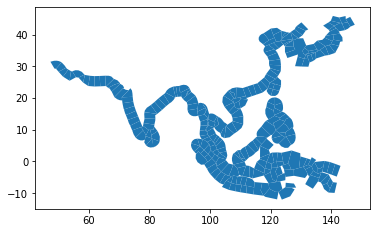

In [19]:
# Load all Parcels
parcels = gpd.read_file(path_parcels)
print(parcels.crs)
parcels.plot()

In [20]:
# Get Country Names
countries = sorted(list(set(parcels['NAME_0'])))
print(countries)
len(countries)

['Bangladesh', 'Cambodia', 'China', 'India', 'Indonesia', 'Iran', 'Japan', 'Malaysia', 'Myanmar', 'North Korea', 'Pakistan', 'Philippines', 'South Korea', 'Sri Lanka', 'Taiwan', 'Thailand', 'Vietnam']


17

In [21]:
# Subset Parcels to one Country; Project to UTM
parcels_one_country = parcels[parcels['NAME_0']==countries[-1]]
parcels_one_country

,GID_0,NAME_0,geometry
113,VTM,Vietnam,"MULTIPOLYGON (((106.79812 22.76943, 106.72292 ..."
114,VTM,Vietnam,"MULTIPOLYGON (((106.01894 22.31722, 107.99597 ..."
115,VTM,Vietnam,"MULTIPOLYGON (((107.77233 18.59714, 104.76500 ..."
116,VTM,Vietnam,"MULTIPOLYGON (((108.10693 17.56432, 106.14062 ..."
117,VTM,Vietnam,"MULTIPOLYGON (((110.06040 16.71273, 107.04268 ..."
118,VTM,Vietnam,"MULTIPOLYGON (((107.42597 13.68468, 107.04268 ..."
119,VTM,Vietnam,"MULTIPOLYGON (((107.49606 12.70821, 107.42597 ..."
120,VTM,Vietnam,"MULTIPOLYGON (((107.18185 12.47396, 107.49606 ..."
121,VTM,Vietnam,"MULTIPOLYGON (((107.18185 12.47396, 108.98270 ..."
122,VTM,Vietnam,"MULTIPOLYGON (((105.25137 11.08708, 107.97842 ..."


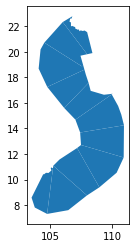

In [22]:
parcels_one_country.plot()

### Load one-country ponds

In [25]:
# Set Path to Ponds of one country
path_ponds = glob(os.path.join(os.getcwd(), 'Aquaculture_ponds_Asian_coast_2019', 'ponds_by_country', '*'+countries[-1]+'*.gpkg'))[0]
# Load Ponds of one country
ponds_one_country = gpd.read_file(path_ponds)
ponds_one_country#.head()

,id,index_right,GID_0,NAME_0,geometry
0,88082,15,VTM,Vietnam,"MULTIPOLYGON (((107.83395 21.60565, 107.83404 ..."
1,88086,15,VTM,Vietnam,"MULTIPOLYGON (((107.83440 21.60511, 107.83440 ..."
2,88088,15,VTM,Vietnam,"MULTIPOLYGON (((107.83467 21.60089, 107.83484 ..."
3,88089,15,VTM,Vietnam,"MULTIPOLYGON (((107.83484 21.60556, 107.83502 ..."
4,88095,15,VTM,Vietnam,"MULTIPOLYGON (((107.83538 21.60466, 107.83538 ..."
...,...,...,...,...,...
662829,88077,15,VTM,Vietnam,"MULTIPOLYGON (((105.27042 9.17863, 105.27042 9..."
662830,88078,15,VTM,Vietnam,"MULTIPOLYGON (((105.27078 9.16587, 105.27078 9..."
662831,88079,15,VTM,Vietnam,"MULTIPOLYGON (((105.27051 9.16488, 105.27060 9..."
662832,88080,15,VTM,Vietnam,"MULTIPOLYGON (((105.27087 9.16129, 105.27096 9..."


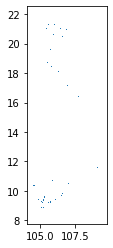

In [26]:
ponds_one_country.plot()

### Subset ponds by parcels, Get one-parcel ponds

In [27]:
# Subset ponds by parcels
parcel_index = parcels_one_country.index
one_parcel = parcels_one_country[parcels_one_country.index==parcel_index[0]]

ponds_one_parcel = ponds_one_country[ponds_one_country.geometry.within(one_parcel.geometry.unary_union)]
ponds_one_parcel

,id,index_right,GID_0,NAME_0,geometry
0,88082,15,VTM,Vietnam,"MULTIPOLYGON (((107.83395 21.60565, 107.83404 ..."
1,88086,15,VTM,Vietnam,"MULTIPOLYGON (((107.83440 21.60511, 107.83440 ..."
2,88088,15,VTM,Vietnam,"MULTIPOLYGON (((107.83467 21.60089, 107.83484 ..."
3,88089,15,VTM,Vietnam,"MULTIPOLYGON (((107.83484 21.60556, 107.83502 ..."
4,88095,15,VTM,Vietnam,"MULTIPOLYGON (((107.83538 21.60466, 107.83538 ..."
...,...,...,...,...,...
59344,159666,15,VTM,Vietnam,"MULTIPOLYGON (((107.09715 20.94728, 107.09715 ..."
59390,159712,15,VTM,Vietnam,"MULTIPOLYGON (((107.17728 20.84765, 107.17755 ..."
59391,159713,15,VTM,Vietnam,"MULTIPOLYGON (((107.17934 20.84487, 107.17952 ..."
59392,159714,15,VTM,Vietnam,"MULTIPOLYGON (((107.17961 20.84541, 107.17961 ..."


In [28]:
ponds_one_parcel_bounds = ponds_one_parcel.bounds
#ponds_one_parcel_bounds
minx = ponds_one_parcel_bounds['minx'].min()
miny = ponds_one_parcel_bounds['miny'].min()
maxx = ponds_one_parcel_bounds['maxx'].max()
maxy = ponds_one_parcel_bounds['maxy'].max()
print(minx, miny, maxx, maxy)

106.78004287743515 20.141486311357436 108.00327879982069 21.60942331713715


In [29]:
# Extract Coordinates of ROI from Parcel Polygons

#parcels_multipoly = parcels_one_country['geometry']
#parcels_multipoly

# Make a list of polygons out of (twice) nested multipolygons
#parcels_poly = [list(i) for i in parcels_multipoly]

# Flatten the list
#parcels_poly = [item for sublist in parcels_poly for item in sublist]
#parcels_poly[:5]

#parcels_borders = [getBorder(i) for i in parcels_poly]
#len(parcels_borders)

In [30]:
#roi = ee.Geometry.Polygon(coords = parcels_borders)

### Reproject ROI?

In [ ]:
prj_crs = 32648

In [ ]:
lons = [minx, minx, maxx, maxx]
lats = [miny, maxy, maxy, miny]
ROI_geom = shp.geometry.Polygon(zip(lons,lats))
ROI = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[ROI_geom])
ROI_prj = ROI.to_crs(prj_crs)

In [ ]:
#ROI_prj_bounds = ROI_prj.bounds

#minx = ROI_prj_bounds['minx'].min()
#miny = ROI_prj_bounds['miny'].min()
#maxx = ROI_prj_bounds['maxx'].max()
#maxy = ROI_prj_bounds['maxy'].max()
#print(minx, miny, maxx, maxy)

In [ ]:
geom = ROI_prj.iloc[i:i+1,:] 
jsonDict = eval(geom.to_json()) 
roi_prj = ee.Feature(geojsonDict)

#features = []
#for i in range(ROI_prj.shape[0]):
#    geom = ROI_prj.iloc[i:i+1,:] 
#    jsonDict = eval(geom.to_json()) 
#    geojsonDict = jsonDict['features'][0] 
#    features.append(ee.Feature(geojsonDict)) 
# https://gis.stackexchange.com/questions/333791/accessing-a-shapefile-with-googleearthengine-api-invalid-geojson-geometry

In [ ]:
roi_prj.geometry().getInfo()

{'coordinates': [[[686057.84810224, 2228133.7385872593],
   [684258.1508686745, 2390650.9475197485],
   [810947.1490593402, 2392599.7870335523],
   [813987.4566734027, 2229973.751081405],
   [686057.84810224, 2228133.7385872593]]],
 'type': 'Polygon'}

## Start Precessing in GEE (roi:Asia)

### *...till annual mndwi*

In [32]:
# Define Study Area
#roi = ee.Geometry.Polygon(coords = parcels_borders[1])#.bounds()
roi = ee.Geometry.Rectangle(coords=[minx, miny, maxx, maxy])
#roi = features.geometry()
roi.getInfo()

{'coordinates': [[[106.78004287743515, 20.141486311357436],
   [108.00327879982069, 20.141486311357436],
   [108.00327879982069, 21.60942331713715],
   [106.78004287743515, 21.60942331713715],
   [106.78004287743515, 20.141486311357436]]],
 'type': 'Polygon'}

In [33]:
# Visualize roi
centroid = roi.centroid().getInfo()['coordinates']
centroid = [centroid[1], centroid[0]]
print(centroid)
Mapdisplay(centroid, {'roi':roi.getInfo()}, zoom_start=3)

[20.87534609345592, 107.39166083862813]


* Note: For larger countries, I need to iterate over each parcel of that country, and mosaic the image ***\<somewhere>*** later.

In [34]:
# Load Satellitie Archive
ls8 = ee.ImageCollection("LANDSAT/LC08/C01/T2_SR") \
        .filterDate('2013', '2020') \
        .select(['B3', 'B5', 'B6', 'pixel_qa'], ['green', 'nir', 'swir', 'pixel_qa']) \
        .filterBounds(roi).sort("system:time_start", True)
ls7 = ee.ImageCollection("LANDSAT/LE07/C01/T1_SR") \
      .filterDate('1999', '2020') \
      .select(['B2', 'B4', 'B5', 'pixel_qa'], ['green', 'nir', 'swir', 'pixel_qa']) \
      .filterBounds(roi).sort("system:time_start", True)
ls5 = ee.ImageCollection("LANDSAT/LT05/C01/T1_SR") \
      .filterDate('1984', '2013') \
      .select(['B2', 'B4', 'B5', 'pixel_qa'], ['green', 'nir', 'swir', 'pixel_qa']) \
      .filterBounds(roi).sort("system:time_start", True)
ls4 = ee.ImageCollection("LANDSAT/LT04/C01/T1_SR") \
      .filterDate('1984', '1994') \
      .select(['B2', 'B4', 'B5', 'pixel_qa'], ['green', 'nir', 'swir', 'pixel_qa']) \
      .filterBounds(roi).sort("system:time_start", True)

ls_all = ls8.merge(ls7).merge(ls5).merge(ls4) \
        .sort('system:time_start', True)\
        .map(maskCloud) \
        #.map(smooth)
print(ls_all.size().getInfo())

1856


In [35]:
print("Spatial resolution: ", ls_all.first().projection().nominalScale().getInfo())

Spatial resolution:  30


* Add NDWI, Subset to NDWI; 

In [36]:
waterIndex = 'mndwi'
ls_all = ls_all.map(addNDWI)
ls_ndwi = ls_all.select([waterIndex])

print(ls_ndwi.size().getInfo())
#ls_ndwi.first().getInfo()

1856


In [37]:
print("Spatial resolution: ", ls_ndwi.first().clip(roi).projection().nominalScale().getInfo())

Spatial resolution:  30


* Group by year, Reduce to annual minimum with 95% quantile applied <br>
https://stackoverflow.com/questions/64311694/google-earth-engine-remove-value-from-s2-ndvi-image-collection-5-and-95-perce


In [38]:
years = ee.List.sequence(1984, 2019)
#waterIndex = 'mndwi'
ls_Treduced = ee.ImageCollection.fromImages(years.map(quantile))
#ls_Treduced = ee.ImageCollection.fromImages(
#      years.map(lambda YEAR: ls_ndwi.filter(ee.Filter.calendarRange(YEAR, YEAR, 'year')) \
#                .median().clip(roi).set({'year': YEAR, 'system:time_start': ee.Date.fromYMD(YEAR, 12, 31)})))


print(ls_Treduced.size().getInfo())
ls_Treduced.first().getInfo()

36


{'bands': [],
 'properties': {'system:index': '0',
  'system:time_start': {'type': 'Date', 'value': 473299200000},
  'year': 1984},
 'type': 'Image'}

In [39]:
test = ls_Treduced.toList(ls_Treduced.size())
testimg = ee.Image(test.get(28))
testimg.projection().nominalScale().getInfo()

111319.49079327357

* (debugged) Filter out the years where no data are available

In [40]:
# Add "bandlength" as new property
ls_filtered = ls_Treduced.map(lambda image: image.set('bandlength', image.bandNames().size()))
# Filter out the years where no data are available
ls_filtered = ls_filtered.filterMetadata('bandlength', 'not_equals', 0)
print(ls_filtered.size().getInfo())
print("Spatial resolution: ", ls_filtered.first().projection().nominalScale().getInfo())
ls_filtered.first().getInfo()

34
Spatial resolution:  111319.49079327357


{'bands': [{'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0],
   'data_type': {'max': 1,
    'min': -1,
    'precision': 'float',
    'type': 'PixelType'},
   'id': 'mndwi'}],
 'properties': {'bandlength': 1,
  'system:index': '2',
  'system:time_start': {'type': 'Date', 'value': 536371200000},
  'year': 1986},
 'type': 'Image'}

In [41]:
imagels = ls_filtered.toList(ls_filtered.size())
print(imagels.size().getInfo())
oneimg = ee.Image(imagels.get(28)).clip(roi)
print('Spatial resolution: ', oneimg.projection().nominalScale().getInfo())
map_id = oneimg.getMapId({'min': -1, 'max': 1, 
                             'palette': ['#ebf5fb', '#d6eaf8', '#aed6f1', '#85c1e9', '#5dade2', '#3498db', '#2e86c1', '#2874a6', '#21618c', '#1b4f72']})

Mapdisplay(centroid, {'Reduced water index':map_id}, zoom_start=5)

34
Spatial resolution:  111319.49079327357


* Reproject to keep the original projection and nominal scale <br>
reference: https://stackoverflow.com/questions/56828085/image-returns-w-different-nominalscale-after-applying-reducer-mean

In [42]:
#ls_rpj = ls_filtered.map(lambda image: image.reproject(crs = ls_ndwi.first().projection(),
#                                                       scale = ls_ndwi.first().projection().nominalScale()))

# Reproject to projected CRS
prj_crs = "EPSG:32648"
ls_rpj = ls_filtered.map(lambda image: image.reproject(crs = prj_crs, scale = 30))
print('Projectoin is: ', ls_rpj.first().projection().getInfo())
print("Spatial resolution: ", ls_rpj.first().projection().nominalScale().getInfo())

Projectoin is:  {'type': 'Projection', 'crs': 'EPSG:32648', 'transform': [30, 0, 0, 0, -30, 0]}
Spatial resolution:  30


* Clip to Country Geometry

In [116]:
#ls_clipped = ls_rpj.map(lambda image: image.clip(roi))
ls_clipped = ls_filtered.map(lambda image: image.clip(roi))
print(ls_clipped.size().getInfo())
print("Spatial resolution: ", ls_clipped.first().projection().nominalScale().getInfo())

34
Spatial resolution:  111319.49079327357


### *the rest*

* Water Segmentation

In [ ]:
ls_wmsk = ls_Treduced.map(thresholding)
#ls_wmsk = ls_Treduced.map(ndwiThreshold)

print(ls_wmsk.size().getInfo())
#ls_wmsk.first().getInfo()

34


In [ ]:
imagels = ls_wmsk.toList(ls_Treduced.size())
print(imagels.size().getInfo())
oneimg = ee.Image(imagels.get(28))
map_id = oneimg.getMapId({'min': 0, 'max': 1, 
                             'palette': ['grey', 'blue']})

Mapdisplay(centroid, {'Reduced water index':map_id}, zoom_start=5)

34


* Change Detection

In [ ]:
list_wmsk = ls_wmsk.toList(ls_wmsk.size())

# Calculate "Backward Gradient", i.e. (Tn+1 - Tn)
ls_grad = list_wmsk.slice(0) \
          .zip(list_wmsk.slice(1)) \
          .map(annual_diff)

ls_84 = ee.List([ls_wmsk.first()])

list_footprint = ls_84.cat(ls_grad) 

ls_footprint = ee.ImageCollection.fromImages(list_footprint)        
print(ls_footprint.size().getInfo())

33


In [ ]:
# Remap value "1" (ponds gain) to "year" of that gain
ls_gain = ls_footprint.select(['watermask']).map(remap_gain).map(unipt)
print(ls_gain.size().getInfo())

33


In [ ]:
fishpond_Gain = ls_gain.mosaic().cast({'gain_year': ee.PixelType('int', 1984, 2019)})
print(fishpond_Gain.getInfo())

{'type': 'Image', 'bands': [{'id': 'gain_year', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 1984, 'max': 2019}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}]}


In [ ]:
fishpond_Gain_id = fishpond_Gain.getMapId({'min': 1984, 'max': 2019, 
                             'palette': ['#ebf5fb', '#d6eaf8', '#aed6f1', '#85c1e9', '#5dade2', '#3498db', '#2e86c1', '#2874a6', '#21618c', '#1b4f72']})
center = [37.18, 118.8]
Mapdisplay(center, {'Footprint Gain': fishpond_Gain_id}, zoom_start = 3)

## Export to Drive

### *Export GeoTiff*

In [94]:
img_clipped = ls_clipped.toBands()#.clip(roi)
print(img_clipped.getInfo())

{'type': 'Image', 'bands': [{'id': '2_mndwi', 'data_type': {'type': 'PixelType', 'precision': 'float', 'min': -1, 'max': 1}, 'dimensions': [3, 2], 'origin': [106, 20], 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': '3_mndwi', 'data_type': {'type': 'PixelType', 'precision': 'float', 'min': -1, 'max': 1}, 'dimensions': [3, 2], 'origin': [106, 20], 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': '4_mndwi', 'data_type': {'type': 'PixelType', 'precision': 'float', 'min': -1, 'max': 1}, 'dimensions': [3, 2], 'origin': [106, 20], 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': '5_mndwi', 'data_type': {'type': 'PixelType', 'precision': 'float', 'min': -1, 'max': 1}, 'dimensions': [3, 2], 'origin': [106, 20], 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': '6_mndwi', 'data_type': {'type': 'PixelType', 'precision': 'float', 'min': -1, 'max': 1}, 'dimensions': [3, 2], 'origin': [106, 20], 'crs': 'EPSG:4326', 'crs_transform': [1,

In [95]:
scale = img_clipped.projection().nominalScale()
print(scale.getInfo())

111319.49079327357


In [ ]:
region = roi.bounds()
region.getInfo()['coordinates']
#boundary = ee.Feature(Countries.first()).geometry().bounds().getInfo()['coordinates']

Taiwan-ndwiXU


[[[119.72619729325359, 23.83863968875773],
  [123.41580910941559, 23.83863968875773],
  [123.41580910941559, 26.631794607658527],
  [119.72619729325359, 26.631794607658527],
  [119.72619729325359, 23.83863968875773]]]

In [96]:
roi.getInfo()['coordinates']

[[[106.78004287743515, 20.141486311357436],
  [108.00327879982069, 20.141486311357436],
  [108.00327879982069, 21.60942331713715],
  [106.78004287743515, 21.60942331713715],
  [106.78004287743515, 20.141486311357436]]]

In [99]:
task_config = {
    'description': 'mndwi1',
    'fileNamePrefix': 'mndwi1',
    'crs': 'EPSG:4326',
    'scale': 30,  
    'region': roi.getInfo()['coordinates'],
    'folder': 'myExportImage',
    'skipEmptyTiles': True,
    'fileFormat': 'GeoTIFF',
    'maxPixels': 10e12
    }
task = ee.batch.Export.image.toDrive(img_clipped, **task_config)
task.start() 
# It takes time until exported images are visible on drive.

# A reference:
# https://gis.stackexchange.com/questions/326131/error-in-export-image-from-google-earth-engine-from-python-api
# https://gis.stackexchange.com/questions/376717/export-multiple-images-from-collection-to-google-drive-not-working-with-google-e

In [ ]:
task.status()

{'attempt': 3,
 'creation_timestamp_ms': 1635959773177,
 'description': 'Taiwan-ndwiXU',
 'id': 'QHGCMFYNOQN62UZTZEHQ6R5M',
 'name': 'projects/earthengine-legacy/operations/QHGCMFYNOQN62UZTZEHQ6R5M',
 'start_timestamp_ms': 1635962867408,
 'state': 'RUNNING',
 'task_type': 'EXPORT_IMAGE',
 'update_timestamp_ms': 1635964970057}

### Export as CSV

In [117]:
# use get region to get a list of long, lat, bandvalue, date
scale = ls_rpj.first().projection().nominalScale()
list_output = ls_clipped.getRegion(roi, scale) # Don't try to print this list
print(scale.getInfo())

30


In [120]:
# Tranform to feat collection (each feat will be a row in Excel export)
names = ee.List(list_output.get(0)) # first row are the names
listIDs = ee.List.sequence(1, list_output.length().subtract(1))
feats = ee.FeatureCollection(listIDs.map(lambda id: ee.Feature(None, ee.Dictionary.fromLists(names, list_output.get(id))).set('ID', id)))
print(feats.first().getInfo())

EEException: ignored

In [92]:
# Export the featureCollection
task_config = {
    'description': countries[-1]+'-mndwi',
    'fileNamePrefix': 'mndwi4',
    #'crs': 'EPSG:4326',
    #'scale': 30,  
    #'region': roi.bounds().getInfo()['coordinates'],
    'folder': 'myExportImage',
    #'skipEmptyTiles': True,
    'fileFormat': 'CSV',
    'selectors': ['ID', 'latitude', 'longitude', waterIndex]#.concat([waterIndex])
    #'maxPixels': 10e12
    }
task = ee.batch.Export.table.toDrive(ls_clipped, **task_config)
task.start() 

#Export.table.toDrive({
#    collection: feats,
#    description: 'foretStGenis',
#    fileFormat: 'CSV',
#    selectors: ['ID', 'latitude', 'longitude'].concat(bandNames)
#})

In [109]:
### TEST ###
# select a band
bandNames = ['treecover2000']

# load dataset
geometry = ee.Geometry.Polygon(
    [[[-98.82986842488617, 30.51973226951964],
    [-98.83055507039398, 30.50701389220806],
    [-98.81956874226898, 30.507235738627383],
    [-98.81871043538422, 30.519806208708616]]])
gfc2014 = ee.Image("UMD/hansen/global_forest_change_2015")
tree = gfc2014.select(bandNames)
#Map.addLayer(tree)

# use get region to get a list of long, lat, bandvalue, date
scale = tree.projection().nominalScale()
listtest = ee.ImageCollection(tree).getRegion(geometry, scale)

# tranform to feat collection (each feat will be a row in Excel export)
names = ee.List(listtest.get(0))
listIDs = ee.List.sequence(1, listtest.length().subtract(1))
feats = ee.FeatureCollection(listIDs.map(lambda id: ee.Feature(None, ee.Dictionary.fromLists(names, listtest.get(id))).set('ID', id)))
#print(feats.limit(2))


# Export the featureCollection
#Export.table.toDrive({
#    collection: feats,
#    description: 'foretStGenis',
#    fileFormat: 'CSV',
#    selectors: ['ID', 'latitude', 'longitude'].concat(bandNames)
#});

task_config = {
    'description': 'foretStGenis',
    #'fileNamePrefix': 'mndwi4',
    #'crs': 'EPSG:4326',
    #'scale': 30,  
    #'region': roi.bounds().getInfo()['coordinates'],
    'folder': 'myExportImage',
    #'skipEmptyTiles': True,
    'fileFormat': 'CSV',
    'selectors': ['ID', 'latitude', 'longitude', 'treecover2000']#.concat([waterIndex])
    #'maxPixels': 10e12
    }
task = ee.batch.Export.table.toDrive(feats, **task_config)
task.start() 

In [113]:
print(feats.first().getInfo())
print(scale.getInfo())
print(tree.projection().getInfo())

{'type': 'Feature', 'geometry': None, 'id': '0', 'properties': {'ID': 1, 'id': '0', 'latitude': 30.507125000000002, 'longitude': -98.830375, 'treecover2000': 0}}
27.829872698318393
{'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [0.00025, 0, -180, 0, -0.00025, 80]}


## Processing in Xarray

### Load Data

In [3]:
import xarray as xr
import rioxarray as rio
from rioxarray import merge
from rasterio.plot import show

* Path to Images

In [4]:
wdir = '/content/drive/My Drive/myExportImage/'
path_images = glob(os.path.join(wdir,'*.tif'))
path_images

['/content/drive/My Drive/myExportImage/mndwi1.tif']

* Load Images as Xarray

In [7]:
xds = rio.open_rasterio(path_images[0])
xds

<xarray.DataArray (band: 34, y: 5453, x: 4540)>
[841725080 values with dtype=float32]
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 ... 26 27 28 29 30 31 32 33 34
  * x            (x) float64 106.8 106.8 106.8 106.8 ... 108.0 108.0 108.0 108.0
  * y            (y) float64 21.61 21.61 21.61 21.61 ... 20.14 20.14 20.14 20.14
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ('2_mndwi', '3_mndwi', '4_mndwi', '5_mndwi', '6_mndwi', '7...

TypeError: ignored

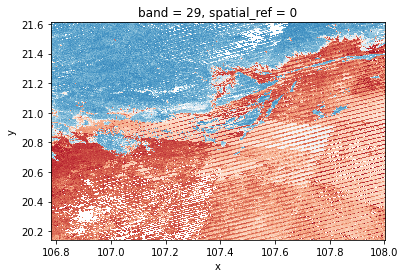

In [6]:
xds[28].plot.imshow()

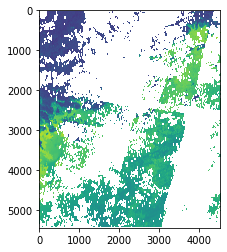

In [124]:
elements = []
#elements = [elements.append(rio.open_rasterio(i)) for i in path_images]
for i in path_images:
    elements.append(rio.open_rasterio(i)[-1])

merged = merge.merge_arrays(elements, nodata=0.0)

image = merged.values
show(image)

In [ ]:
merged

<xarray.DataArray (y: 10410, x: 13692)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x            (x) float64 119.7 119.7 119.7 119.7 ... 123.4 123.4 123.4 123.4
  * y            (y) float64 26.64 26.64 26.64 26.64 ... 23.84 23.84 23.84 23.84
    band         int64 35
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ('0_ndwiXU', '2_ndwiXU', '3_ndwiXU', '4_ndwiXU', '5_ndwiXU...
    _FillValue:    0.0

### Try with wxarray

In [ ]:
ls_clipped.wx.to_xarray(path='/content/drive/My Drive/myExportImage/', scale=30)

Requesting data:   0%|          | 0/34 [00:00<?, ?it/s]

EEException: ignored

In [ ]:
xr_ndwiXU = ls_clipped.wx.to_xarray(scale=300)
xr_ndwiXU

Requesting data:   0%|          | 0/34 [00:00<?, ?it/s]

HTTPError: ignored

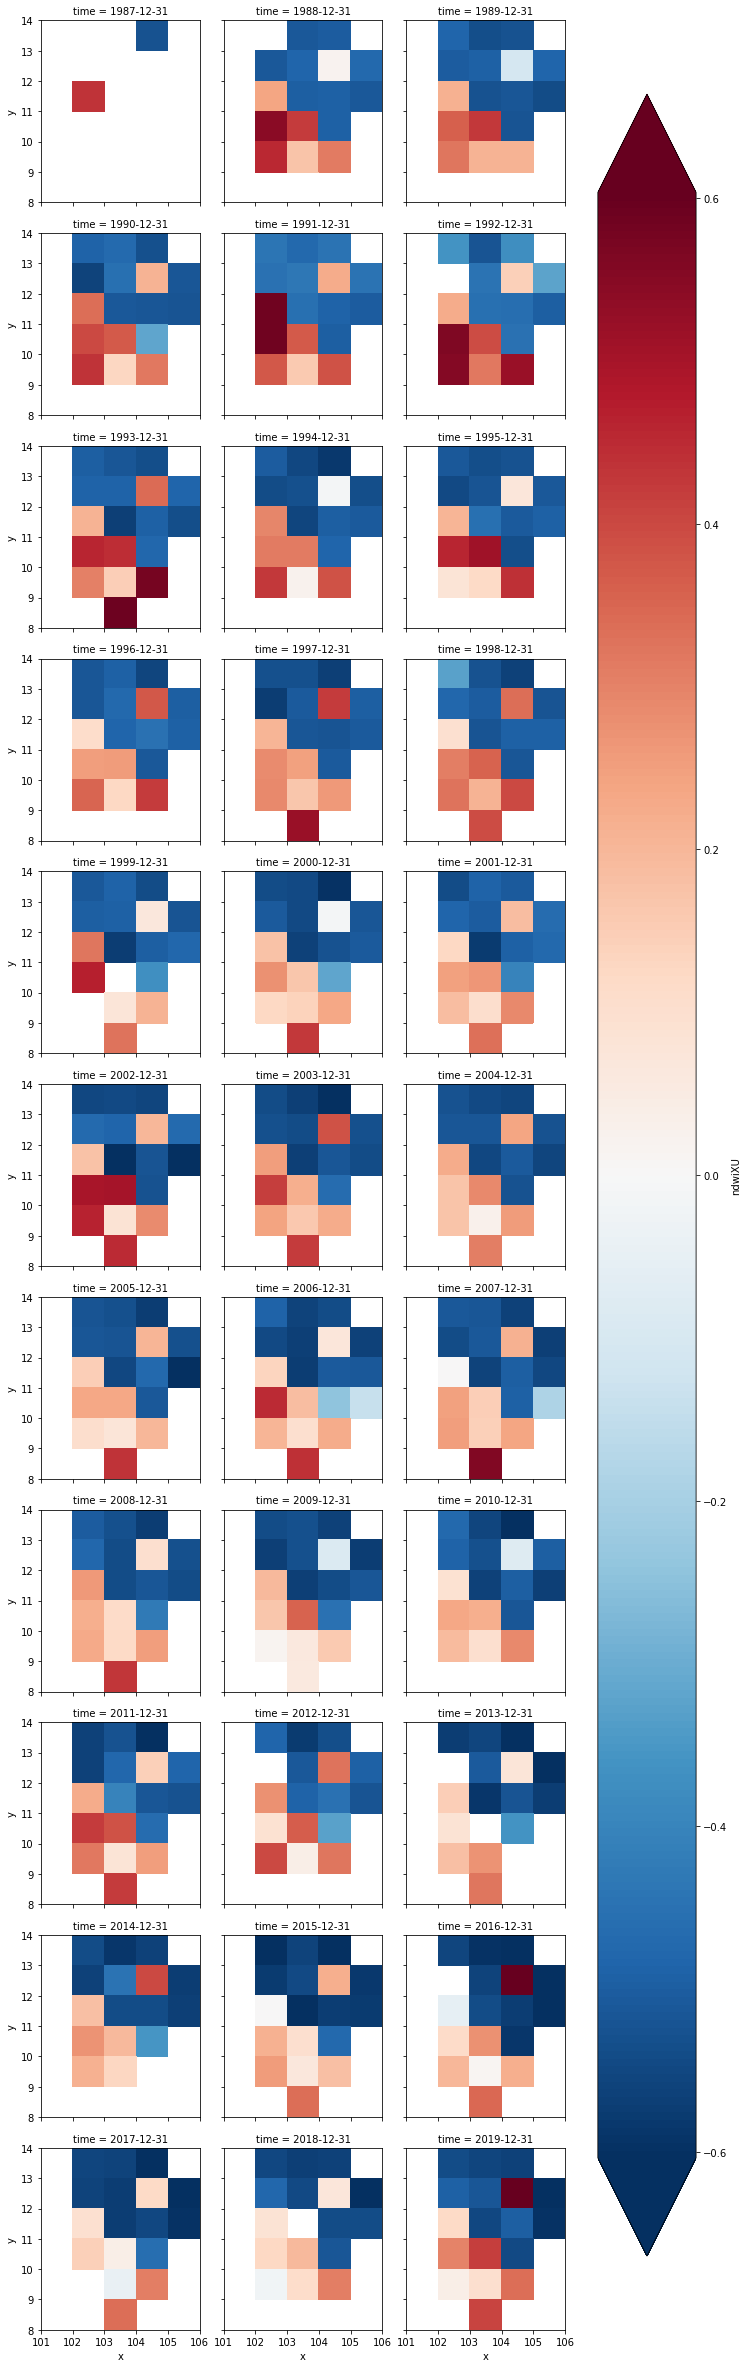

In [ ]:
xr_ndwiXU.ndwiXU.plot(robust=True, col="time", col_wrap=3)

### ***(To be done...) Interpolate to fill the missing data gaps.***
!! **Using `xarray` or `rioxarray`**

## GEE to Numpy Array
...**User limit exceeded at "reduceByRegion()"**...

### Using **`reduceRegion(s)`**



In [ ]:
import numpy as np
from osgeo import gdal
from osgeo import osr
import time
import matplotlib.pyplot as plt
 
# init the ee object
#ee.Initialize()

In [ ]:
ee.FeatureCollection(ee.Feature(roi)).getInfo()

{'columns': {'system:index': 'String'},
 'features': [{'geometry': {'coordinates': [[[106.78004287743515,
       20.141486311357436],
      [108.00327879982069, 20.141486311357436],
      [108.00327879982069, 21.60942331713715],
      [106.78004287743515, 21.60942331713715],
      [106.78004287743515, 20.141486311357436]]],
    'type': 'Polygon'},
   'id': '0',
   'properties': {},
   'type': 'Feature'}],
 'type': 'FeatureCollection'}

In [ ]:
# perform any calculation on the image collection here
def anyFunction(img):
    ndvi = ee.Image(img.normalizedDifference(['B8', 'B4'])).rename(["ndvi"])
    return ndvi
 
# export the latitude, longitude and array
def LatLonImg(img):
    img = img.addBands(ee.Image.pixelLonLat())
    img = img.reduceRegion(reducer=ee.Reducer.toList(),\
                           geometry=roi,\
                           maxPixels=1e13,\
                           tileScale=16,\
                           scale=30)
    #img = img.reduceRegions(reducer=ee.Reducer.toList(),\
    #                       collection=ee.FeatureCollection(ee.Feature(roi)),\
    #                       #maxPixels=1e13,\
    #                       tileScale=16,\
    #                       scale=30)
 
    data = np.array((ee.Array(img.get(waterIndex)).getInfo()))
    lats = np.array((ee.Array(img.get("latitude")).getInfo()))
    lons = np.array((ee.Array(img.get("longitude")).getInfo()))
    return lats, lons, data
 
# covert the lat, lon and array into an image
def toImage(lats,lons,data):
 
    # get the unique coordinates
    uniqueLats = np.unique(lats)
    uniqueLons = np.unique(lons)
 
    # get number of columns and rows from coordinates
    ncols = len(uniqueLons)
    nrows = len(uniqueLats)
 
    # determine pixelsizes
    ys = uniqueLats[1] - uniqueLats[0]
    xs = uniqueLons[1] - uniqueLons[0]
 
    # create an array with dimensions of image
    arr = np.zeros([nrows, ncols], np.float32) #-9999
 
    # fill the array with values
    counter =0
    for y in range(0,len(arr),1):
        for x in range(0,len(arr[0]),1):
            if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
                counter+=1
                arr[len(uniqueLats)-1-y,x] = data[counter] # we start from lower left corner
    return arr

In [ ]:
# Define the roi
#area = ee.Geometry.Polygon([[105.4084512289977,12.960956032145036],\
#                            [105.46544280614614,12.960956032145036],\
#                            [105.46544280614614,13.006454200439705],\
#                            [105.4084512289977,13.006454200439705],\
#                            [105.4084512289977,12.960956032145036]])
 
# define the image
#collection = ee.ImageCollection("COPERNICUS/S2").filterBounds(area)\
#                                      .filterDate("2018-01-01","2019-01-10")\
#                                      .filterMetadata("CLOUDY_PIXEL_PERCENTAGE","less_than",10)\
#                                      .select(['B8', 'B4'])
 
print(" number of image: ", ls_clipped.size().getInfo())


# map over the image collection
#myCollection  = collection.map(anyFunction)
 
# get the median
#result = ee.Image(myCollection.median()).rename(['result'])
result2 = ee.Image(ls_clipped.toList(ls_clipped.size()).get(0))
 
# get the lon, lat and result as 1d array
lat, lon, data = LatLonImg(result2)
 
# 1d to 2d array
image  = toImage(lat,lon,data)
 
# in case you want to plot the image
plt.imshow(image)
plt.show()

 number of image:  34


EEException: ignored

### Using **`SampleRectangle`**

In [ ]:
testlist = ls_clipped.toList(ls_clipped.size())
testimgCo = ee.Image(testlist.get(0))
#testimgCo.getInfo()

In [ ]:
print(roi_prj.geometry().projection().getInfo())
print(ls_filtered.first().projection().getInfo())
print(ls_clipped.first().projection().getInfo())

{'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}
{'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}
{'type': 'Projection', 'crs': 'EPSG:32648', 'transform': [30, 0, 0, 0, -30, 0]}


In [ ]:
lala = testimgCo.sampleRectangle(region = roi_prj.geometry())
lala.getInfo()

EEException: ignored

## CSV --> Xarray

In [66]:
import pandas as pd

In [104]:
wdir = '/content/drive/My Drive/myExportImage/'
path_csv = glob(os.path.join(wdir, '*.csv'))
path_csv

['/content/drive/My Drive/myExportImage/mndwi1.csv',
 '/content/drive/My Drive/myExportImage/mndwi2.csv',
 '/content/drive/My Drive/myExportImage/mndwi3.csv',
 '/content/drive/My Drive/myExportImage/mndwi4.csv',
 '/content/drive/My Drive/myExportImage/foretStGenis.csv']

In [105]:
my_csv = pd.read_csv(path_csv[-1])
my_csv

,ID,latitude,longitude,treecover2000
0,1.0,30.507125,-98.830375,0
1,2.0,30.507125,-98.830125,0
2,3.0,30.507125,-98.829875,0
3,4.0,30.507125,-98.829625,0
4,5.0,30.507125,-98.829375,0
...,...,...,...,...
2232,2233.0,30.519625,-98.819875,0
2233,2234.0,30.519625,-98.819625,0
2234,2235.0,30.519625,-98.819375,0
2235,2236.0,30.519625,-98.819125,0
